# Imports, load data

In [71]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from distance_determination import get_current_freq
from simul.utilities.data import load_experiment
from simul.vis.signals import vis_signals
from tqdm.auto import tqdm, trange

In [81]:
params, dist, signals_data, dist_probs = load_experiment("default_full")

# VIS

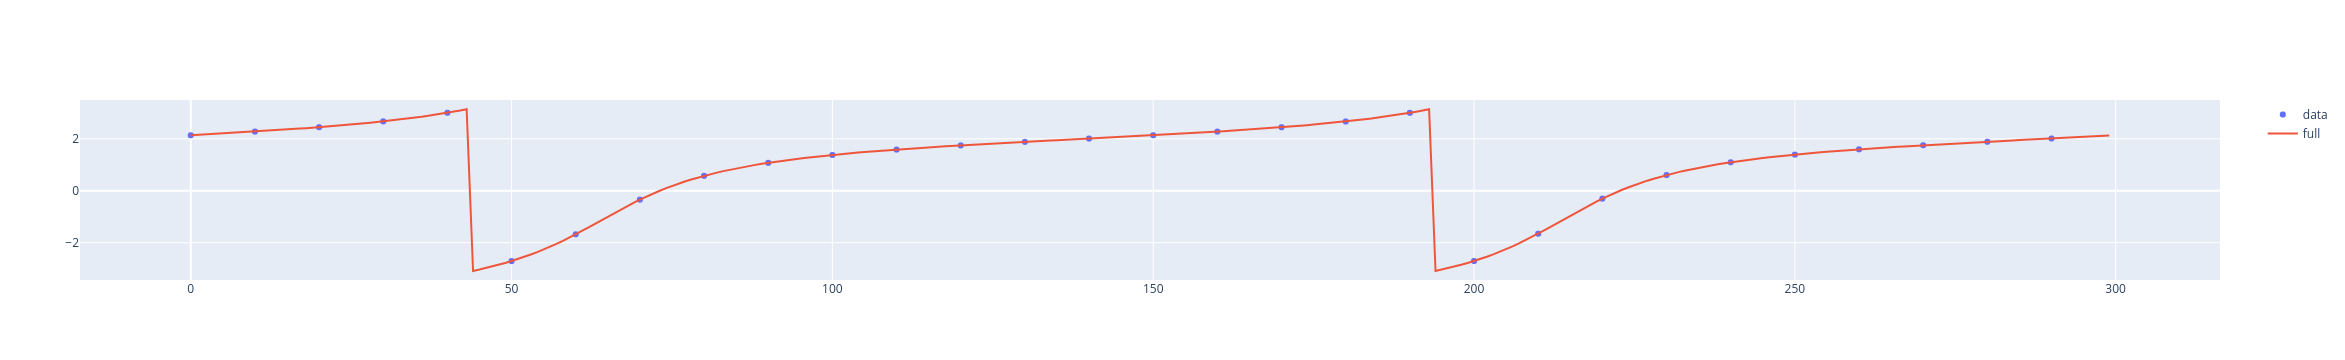

In [45]:
y = np.angle(signals_data_full[0, ...])
x = y.copy()

step = 10
x[[True if i % step else False for i in range(len(x))]] = np.nan


n = 300
fig = go.Figure()
fig.add_trace(go.Scatter(y=x[:n], name="data", mode="markers"))
fig.add_trace(go.Scatter(y=y[:n], name="full"))
fig

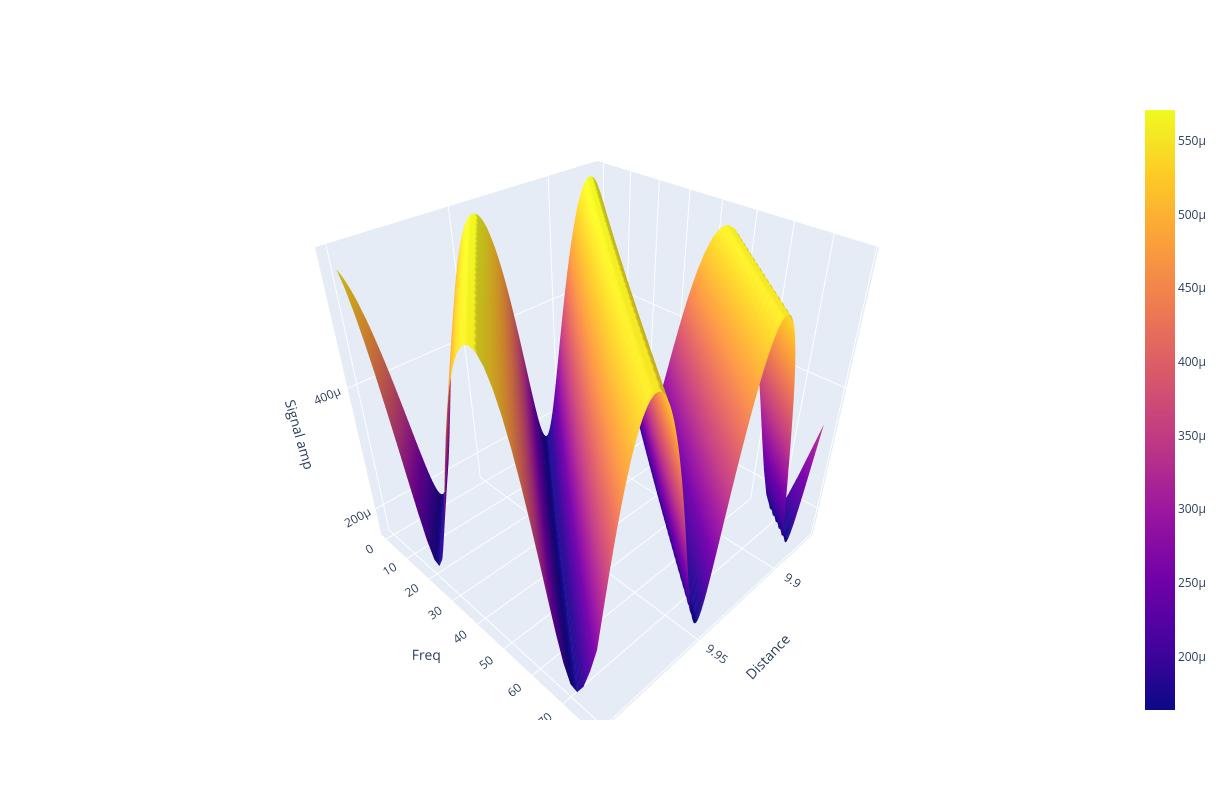

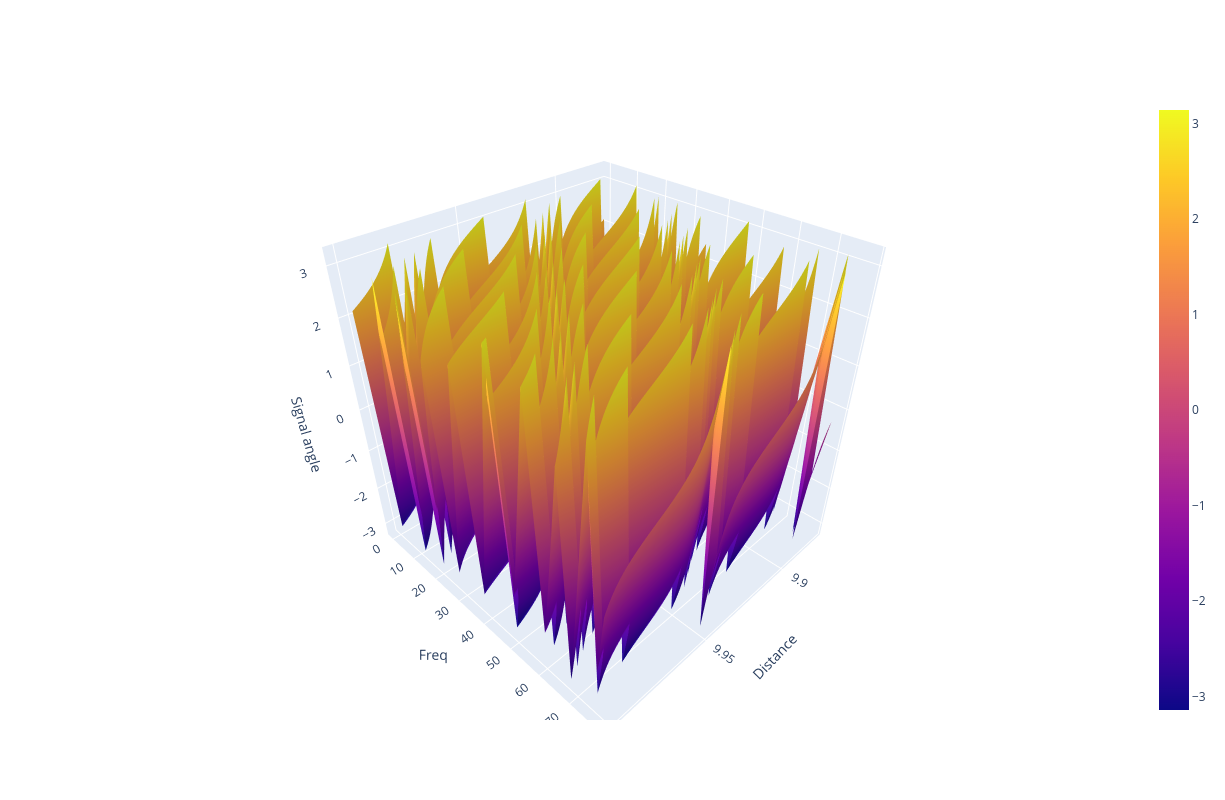

In [82]:
fig_amp, fig_angle = vis_signals(signals_data, dist, params, 300, dump=True)

fig_amp.update_layout(height=800)
fig_amp.show()

fig_angle.update_layout(height=800)
fig_angle.show()

# Whittaker–Shannon

In [64]:
def wsinterp(x, xp, fp, left=None, right=None):
    """One-dimensional Whittaker-Shannon interpolation.

    This uses the Whittaker-Shannon interpolation formula to interpolate the
    value of fp (array), which is defined over xp (array), at x (array or
    float).

    Returns the interpolated array with dimensions of x.

    """
    scalar = np.isscalar(x)
    if scalar:
        x = np.array(x)
        x.resize(1)
    # shape = (nxp, nx), nxp copies of x data span axis 1
    u = np.resize(x, (len(xp), len(x)))
    # Must take transpose of u for proper broadcasting with xp.
    # shape = (nx, nxp), v(xp) data spans axis 1
    v = (xp - u.T) / (xp[1] - xp[0])
    # shape = (nx, nxp), m(v) data spans axis 1
    m = fp * np.sinc(v)
    # Sum over m(v) (axis 1)
    fp_at_x = np.sum(m, axis=1)

    # Enforce left and right
    if left is None:
        left = fp[0]
    fp_at_x[x < xp[0]] = left
    if right is None:
        right = fp[-1]
    fp_at_x[x > xp[-1]] = right

    # Return a float if we got a float
    if scalar:
        return float(fp_at_x)

    return fp_at_x

In [70]:
wsinterp(np.arange(len(x)), np.squeeze(np.argwhere(~np.isnan(x))), x[~np.isnan(x)])

array([2.13696337, 2.21617368, 2.26318806, ..., 2.92186308, 2.92186308,
       2.92186308])

In [78]:
y = np.angle(signals_data_full[0, ...])
interps = {}

for step in trange(2, 60, 10):
    x = y.copy()

    x[[True if i % step else False for i in range(len(x))]] = np.nan
    x_interp = wsinterp(
        np.arange(len(x)), np.squeeze(np.argwhere(~np.isnan(x))), x[~np.isnan(x)]
    )
    interps[step] = x_interp

  0%|          | 0/6 [00:00<?, ?it/s]

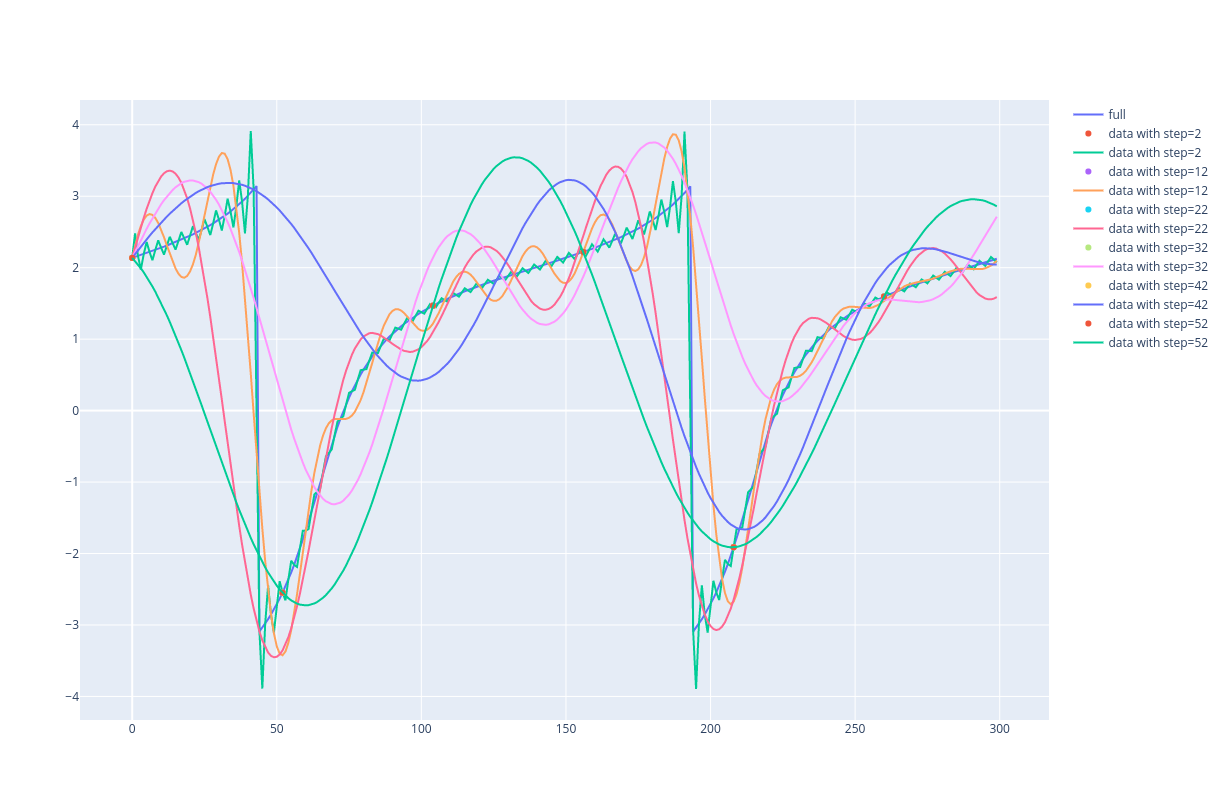

In [79]:
n = 300
fig = go.Figure()
fig.add_trace(go.Scatter(y=y[:n], name="full"))

for step, x_interp in interps.items():
    fig.add_trace(go.Scatter(y=x[:n], name=f"data with {step=}", mode="markers"))
    fig.add_trace(go.Scatter(y=x_interp[:n], name=f"data with {step=}"))

fig.update_layout(height=800)
fig